# Clustering 

In [1]:
# Load Libraries
import pandas as pd
import re
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV

from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

import itertools
import numpy as np
import seaborn as sns

# machine learning
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
#from xgboost import XGBRegressor

#warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#Load the data

df_movies = pd.read_csv("classificationPreprocessingGeneral.csv")
print("Length after import: " + str(len(df_movies)))
df_movies = df_movies.fillna(0)
print(df_movies.head(5))
df_movies.columns

Length after import: 43872
     budget     id  runtime  Documentary  Foreign  Action  Horror  War  \
0  30000000    862     81.0          0.0      0.0     0.0     0.0  0.0   
1  65000000   8844    104.0          0.0      0.0     0.0     0.0  0.0   
2         0  15602    101.0          0.0      0.0     0.0     0.0  0.0   
3  16000000  31357    127.0          0.0      0.0     0.0     0.0  0.0   
4         0  11862    106.0          0.0      0.0     0.0     0.0  0.0   

   Romance  Adventure  ...  actor_Donald Sutherland  actor_Robert De Niro  \
0      0.0        0.0  ...                        0                     0   
1      0.0        1.0  ...                        0                     0   
2      1.0        0.0  ...                        0                     0   
3      1.0        0.0  ...                        0                     0   
4      0.0        0.0  ...                        0                     0   

   actor_Samuel L. Jackson  actor_Jackie Chan  actor_Michael Cain

Index(['budget', 'id', 'runtime', 'Documentary', 'Foreign', 'Action', 'Horror',
       'War', 'Romance', 'Adventure', 'Thriller', 'History', 'Drama', 'Family',
       'Comedy', 'TV Movie', 'Crime', 'Western', 'Mystery', 'Fantasy',
       'Animation', 'Music', 'Science Fiction', 'part_of_collection', '+18',
       'hasHomepage', '18+', 'spokenLanguages', 'movieId', 'imdbId',
       'director', 'actors', 'pcomp_Orion Pictures', 'pcomp_New Line Cinema',
       'pcomp_Gaumont', 'pcomp_Twentieth Century Fox Film Corporation',
       'pcomp_Walt Disney Productions', 'pcomp_Paramount Pictures',
       'pcomp_Universal Pictures', 'pcomp_Village Roadshow Pictures',
       'pcomp_StudioCanal', 'pcomp_Columbia Pictures Corporation',
       'pcomp_Regency Enterprises', 'pcomp_Touchstone Pictures',
       'pcomp_Mosfilm', 'pcomp_RKO Radio Pictures', 'pcomp_Miramax Films',
       'pcomp_TriStar Pictures', 'pcomp_Columbia Pictures',
       'pcomp_Toho Company', 'pcomp_Relativity Media',
       'pcomp

After we loaded all the libaries and data that we need, we can start with the classification tasks.

Since we have a lot of features it makes sense to eliminate features that do not have a significant impact on the prediction to improve our perfromance. Also we have to drop the columns that are anyways not needed like to actor column, which got one hot encoded already in preprocessing or the ids of the movie...

In [3]:
# drop columns that are not needed maybe implement feature selction...



features_to_remove = ['actors', 'movieId', 'imdbId', 'id', '+18','spokenLanguages'
                     ]
for i in features_to_remove:
    if i in df_movies.columns:
        df_movies = df_movies.drop(columns=i)
print(df_movies.head(5))
df_movies.columns

     budget  runtime  Documentary  Foreign  Action  Horror  War  Romance  \
0  30000000     81.0          0.0      0.0     0.0     0.0  0.0      0.0   
1  65000000    104.0          0.0      0.0     0.0     0.0  0.0      0.0   
2         0    101.0          0.0      0.0     0.0     0.0  0.0      1.0   
3  16000000    127.0          0.0      0.0     0.0     0.0  0.0      1.0   
4         0    106.0          0.0      0.0     0.0     0.0  0.0      0.0   

   Adventure  Thriller  ...  actor_Donald Sutherland  actor_Robert De Niro  \
0        0.0       0.0  ...                        0                     0   
1        1.0       0.0  ...                        0                     0   
2        0.0       0.0  ...                        0                     0   
3        0.0       0.0  ...                        0                     0   
4        0.0       0.0  ...                        0                     0   

   actor_Samuel L. Jackson  actor_Jackie Chan  actor_Michael Caine  \
0   

Index(['budget', 'runtime', 'Documentary', 'Foreign', 'Action', 'Horror',
       'War', 'Romance', 'Adventure', 'Thriller', 'History', 'Drama', 'Family',
       'Comedy', 'TV Movie', 'Crime', 'Western', 'Mystery', 'Fantasy',
       'Animation', 'Music', 'Science Fiction', 'part_of_collection',
       'hasHomepage', '18+', 'director', 'pcomp_Orion Pictures',
       'pcomp_New Line Cinema', 'pcomp_Gaumont',
       'pcomp_Twentieth Century Fox Film Corporation',
       'pcomp_Walt Disney Productions', 'pcomp_Paramount Pictures',
       'pcomp_Universal Pictures', 'pcomp_Village Roadshow Pictures',
       'pcomp_StudioCanal', 'pcomp_Columbia Pictures Corporation',
       'pcomp_Regency Enterprises', 'pcomp_Touchstone Pictures',
       'pcomp_Mosfilm', 'pcomp_RKO Radio Pictures', 'pcomp_Miramax Films',
       'pcomp_TriStar Pictures', 'pcomp_Columbia Pictures',
       'pcomp_Toho Company', 'pcomp_Relativity Media',
       'pcomp_Walt Disney Pictures', 'pcomp_BBC Films', 'pcomp_United Artist

Now that we have exactly the data we want we start with the spitting.

1. First of all we separate the features from our targte(the rating).
2. We split our data into training and test data in order to evaluate our model later. The proportions will be 60% to 40%
3. We create a kfold cross validation that we will later use for our models in order to evaluate them better
4. We encode data that needs to be encoded -> ratings and directors

In [4]:
# specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# separate features and target variable
rating = df_movies['Rating_Label'] # weight
features = df_movies.drop(columns=['Rating_Label'])

# encode labels
lab_enc = LabelEncoder()
rating = lab_enc.fit_transform(rating)
features["director"] = features["director"].astype(str)
features["director"] = lab_enc.fit_transform(features["director"])

# create a train/test split
features_train, features_test, rating_train, rating_test = train_test_split(features, rating, test_size=0.4, random_state=42, stratify=rating )

print("Train: " + str(len(features_train)) + " Features and " + str(len(rating_train)) + " Ratings")
print("Test: " + str(len(features_test)) + " Features and " + str(len(rating_test)) + " Ratings")


Train: 26323 Features and 26323 Ratings
Test: 17549 Features and 17549 Ratings


# Initial evaluation of different classifiers

In [5]:
##### create and fit a RandomForestClassifier
rf_reg = RandomForestClassifier()
rf_reg.fit(features_train, rating_train)
rating_pred_rf = rf_reg.predict(features_test)

print("Scores Random Forest:")
#compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_rf)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_rf)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_rf, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_rf, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_rf, average='weighted')))
print()

##### create and fit a KNN
knn_reg = KNeighborsClassifier()
knn_reg.fit(features_train, rating_train)
rating_pred_knn = knn_reg.predict(features_test)

print("Scores knn:")
# #compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_knn)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_knn)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_knn, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_knn, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_knn, average='weighted')))
print()

##### create and fit a DecisionTreeClassifier
dt_reg = DecisionTreeClassifier()
dt_reg.fit(features_train, rating_train)
rating_pred_dt = dt_reg.predict(features_test)

print("Scores Decision Tree:")
#compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_dt)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_dt)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_dt, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_dt, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_dt, average='weighted')))
print()

##### create and fit a GaussianNB
nb_reg = GaussianNB()
nb_reg.fit(features_train, rating_train)
rating_pred_nb = nb_reg.predict(features_test)

print("Scores Naive Bayes:")
# #compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_nb)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_nb)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_nb, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_nb, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_nb, average='weighted')))
print()

##### create and fit a SVC
svc_reg = LinearSVC()
svc_reg.fit(features_train, rating_train)
rating_pred_svc = svc_reg.predict(features_test)

print("Scores SVC:")
#compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_svc)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_svc)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_svc, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_svc, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_svc, average='weighted')))
print()

#plot the confusion matrix
#plot_confusion_matrix(cnf_matrix, classes=lab_enc.classes_, title='KNN Classifier')

print()

# metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))



C:\Users\d060445\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores Random Forest:
Accuracy: 0.45757593025243604
Precision: 0.4249071669646724
Recall: 0.45757593025243604
f1_score: 0.43665658841356303

Scores knn:
Accuracy: 0.4457803863468004
Precision: 0.38925695496372326
Recall: 0.4457803863468004
f1_score: 0.4052913082091328

Scores Decision Tree:
Accuracy: 0.40982392159097386
Precision: 0.41564729616972307
Recall: 0.40982392159097386
f1_score: 0.412654803634187

Scores Naive Bayes:
Accuracy: 0.5286341102057097
Precision: 0.27945402247298246
Recall: 0.5286341102057097
f1_score: 0.36562578396916195



C:\Users\d060445\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\d060445\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Scores SVC:
Accuracy: 0.4450965867000969
Precision: 0.4119594594528054
Recall: 0.4450965867000969
f1_score: 0.3730537206521399




C:\Users\d060445\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## It seems that KNN & Random Forrest are the best classifiers. With those two we will now do some parameter tuning...

We will see with wich k the algorithm works best:

In [6]:
# create and fit a knn classifier
knn_reg = KNeighborsClassifier()

knn_reg.fit(features_train, rating_train)
rating_pred_knn = knn_reg.predict(features_test)

print("Scores knn:")

# specify the parameter grid
parameters = {
    'n_neighbors': range(2, 30)
}


# create the grid search instance
grid_search_estimator = GridSearchCV(knn_reg, parameters, scoring='accuracy', cv=stratified_10_fold_cv, return_train_score=False)

# run the grid search
grid_search_estimator.fit(features_train, rating_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
#display(results)
    
# print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

Scores knn:
best score is 0.5151768415454165 with params {'n_neighbors': 29}


Scores knn:
Fold 0: Accuracy = 51.04364326375711%
Fold 1: Accuracy = 51.93621867881549%
Fold 2: Accuracy = 52.3538344722855%
Fold 3: Accuracy = 51.290812452543655%
Fold 4: Accuracy = 51.46221040638056%
Fold 5: Accuracy = 51.51975683890577%
Fold 6: Accuracy = 51.5773470163436%
Fold 7: Accuracy = 52.28136882129277%
Fold 8: Accuracy = 51.33079847908745%
Fold 9: Accuracy = 50.38022813688213%
Average Accuracy = 51.517621856629404%

Accuracy on Test Data: 0.5160408000455866
f1_score on Test Data: 0.3942884289004468
Confusion matrix, without normalization
[[   0    0  514   22    0]
 [   0    0 2226   73    0]
 [   0    0 8663  614    0]
 [   0    0 4403  714    0]
 [   0    0  272   48    0]]


C:\Users\d060445\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


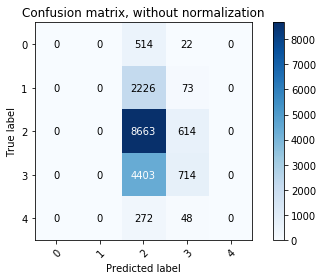

In [15]:
# do now Knn with k = 29 and applie 10 cross fold

# create and fit a knn classifier
knn_reg = KNeighborsClassifier(n_neighbors=29)

knn_reg.fit(features_train, rating_train)
rating_pred_knn = knn_reg.predict(features_test)

print("Scores knn:")


#compute accuracy score

accuracy_knn = cross_val_score(knn_reg, features_train, rating_train, cv=stratified_10_fold_cv, scoring='accuracy')

for i, acc in enumerate(accuracy_knn):
    print("Fold {}: Accuracy = {}%".format(i, acc * 100.0))

print("Average Accuracy = {}%".format(accuracy_knn.mean() * 100.0))
print()
print("Accuracy on Test Data: {}".format(accuracy_score(rating_test, rating_pred_knn)))
print("f1_score on Test Data: {}".format(f1_score(rating_test, rating_pred_knn, average='weighted')))

class_names = ['0','1','2','3','4','5']


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(rating_test, rating_pred_rf, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()


Tuning of Random forrest:

In [8]:
##### create and fit a RandomForestClassifier
rf_reg = RandomForestClassifier()
rf_reg.fit(features_train, rating_train)
rating_pred_rf = rf_reg.predict(features_test)

#Tuning of algorithm

# specify the parameter grid
parameters = {
    'max_depth':[3,5,10,None],
     'criterion':["gini", "entropy"],
     'max_features':["auto","log2",None]
}


# create the grid search instance
grid_search_estimator = GridSearchCV(rf_reg, parameters, scoring='accuracy', cv=stratified_10_fold_cv, return_train_score=False)

# run the grid search
grid_search_estimator.fit(features_train, rating_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
#display(results)
    
# print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))




print()


C:\Users\d060445\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


best score is 0.5419595030961517 with params {'criterion': 'entropy', 'max_depth': 3, 'max_features': None}



C:\Users\d060445\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores Random Forrest:
Fold 0: Accuracy = 54.307400379506646%
Fold 1: Accuracy = 54.51784358390282%
Fold 2: Accuracy = 54.32801822323462%
Fold 3: Accuracy = 53.568716780561886%
Fold 4: Accuracy = 54.99430307633878%
Fold 5: Accuracy = 54.21732522796353%
Fold 6: Accuracy = 54.00988217407829%
Fold 7: Accuracy = 54.030418250950575%
Fold 8: Accuracy = 53.68821292775665%
Fold 9: Accuracy = 54.29657794676807%
Average Accuracy = 54.19586985710618%

Accuracy on Test Data: 0.5343324405949057
f1_score on Test Data: 0.4244380412662057
Confusion matrix, without normalization
[[   0    0  514   22    0]
 [   0    0 2226   73    0]
 [   0    0 8663  614    0]
 [   0    0 4403  714    0]
 [   0    0  272   48    0]]


C:\Users\d060445\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


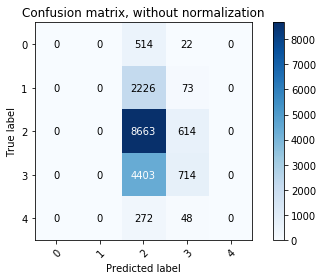

In [14]:
# do now Random Forest with entropy, maxdeepth 3 and applie 10 cross fold

##### create and fit a RandomForestClassifier
rf_reg = RandomForestClassifier(criterion='entropy', max_depth=3, max_features=None)
rf_reg.fit(features_train, rating_train)
rating_pred_rf = rf_reg.predict(features_test)

print("Scores Random Forrest:")


#compute accuracy score

accuracy_knn = cross_val_score(rf_reg, features_train, rating_train, cv=stratified_10_fold_cv, scoring='accuracy')

for i, acc in enumerate(accuracy_knn):
    print("Fold {}: Accuracy = {}%".format(i, acc * 100.0))

print("Average Accuracy = {}%".format(accuracy_knn.mean() * 100.0))
print()
print("Accuracy on Test Data: {}".format(accuracy_score(rating_test, rating_pred_rf)))
print("f1_score on Test Data: {}".format(f1_score(rating_test, rating_pred_rf, average='weighted')))

class_names = ['0','1','2','3','4','5']


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(rating_test, rating_pred_rf, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()


In [13]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Analysis of Modell with Cluster Data

In [17]:
#Load the data

df_movies_cluster = pd.read_csv("classificationPreprocessingWithClustering.csv")
print("Length after import: " + str(len(df_movies)))
df_movies_cluster = df_movies.fillna(0)
print(df_movies_cluster.head(5))
df_movies_cluster.columns

Length after import: 118856
   usercluster  movieId    budget   id  runtime  Documentary  Foreign  Action  \
0            0        1  30000000  862     81.0          0.0      0.0     0.0   
1            1        1  30000000  862     81.0          0.0      0.0     0.0   
2            2        1  30000000  862     81.0          0.0      0.0     0.0   
3            3        1  30000000  862     81.0          0.0      0.0     0.0   
4            4        1  30000000  862     81.0          0.0      0.0     0.0   

   Horror  War  ...  actor_Donald Sutherland  actor_Robert De Niro  \
0     0.0  0.0  ...                        0                     0   
1     0.0  0.0  ...                        0                     0   
2     0.0  0.0  ...                        0                     0   
3     0.0  0.0  ...                        0                     0   
4     0.0  0.0  ...                        0                     0   

   actor_Samuel L. Jackson  actor_Jackie Chan  actor_Michael Cai

Index(['usercluster', 'movieId', 'budget', 'id', 'runtime', 'Documentary',
       'Foreign', 'Action', 'Horror', 'War', 'Romance', 'Adventure',
       'Thriller', 'History', 'Drama', 'Family', 'Comedy', 'TV Movie', 'Crime',
       'Western', 'Mystery', 'Fantasy', 'Animation', 'Music',
       'Science Fiction', 'part_of_collection', '+18', 'hasHomepage', '18+',
       'spokenLanguages', 'imdbId', 'rating_y', 'director', 'actors',
       'pcomp_Orion Pictures', 'pcomp_New Line Cinema', 'pcomp_Gaumont',
       'pcomp_Twentieth Century Fox Film Corporation',
       'pcomp_Walt Disney Productions', 'pcomp_Paramount Pictures',
       'pcomp_Universal Pictures', 'pcomp_Village Roadshow Pictures',
       'pcomp_StudioCanal', 'pcomp_Columbia Pictures Corporation',
       'pcomp_Regency Enterprises', 'pcomp_Touchstone Pictures',
       'pcomp_Mosfilm', 'pcomp_RKO Radio Pictures', 'pcomp_Miramax Films',
       'pcomp_TriStar Pictures', 'pcomp_Columbia Pictures',
       'pcomp_Toho Company', 'pcom

The Data set is similair, we just have and additional column usercluster. In order to have comparable results we remove the same columns as in the previous set:

In [32]:
# drop columns that are not needed maybe implement feature selction...



features_to_remove = ['actors', 'movieId', 'imdbId', 'id', '+18','spokenLanguages', 'rating_y'
                     ]
for i in features_to_remove:
    if i in df_movies_cluster.columns:
        df_movies_cluster = df_movies_cluster.drop(columns=i)
print(len(df_movies_cluster))
print(df_movies_cluster.usercluster.unique())
df_movies_cluster.columns



118856
[0 1 2 3 4 5 6 7 8]


Index(['usercluster', 'budget', 'runtime', 'Documentary', 'Foreign', 'Action',
       'Horror', 'War', 'Romance', 'Adventure', 'Thriller', 'History', 'Drama',
       'Family', 'Comedy', 'TV Movie', 'Crime', 'Western', 'Mystery',
       'Fantasy', 'Animation', 'Music', 'Science Fiction',
       'part_of_collection', 'hasHomepage', '18+', 'director',
       'pcomp_Orion Pictures', 'pcomp_New Line Cinema', 'pcomp_Gaumont',
       'pcomp_Twentieth Century Fox Film Corporation',
       'pcomp_Walt Disney Productions', 'pcomp_Paramount Pictures',
       'pcomp_Universal Pictures', 'pcomp_Village Roadshow Pictures',
       'pcomp_StudioCanal', 'pcomp_Columbia Pictures Corporation',
       'pcomp_Regency Enterprises', 'pcomp_Touchstone Pictures',
       'pcomp_Mosfilm', 'pcomp_RKO Radio Pictures', 'pcomp_Miramax Films',
       'pcomp_TriStar Pictures', 'pcomp_Columbia Pictures',
       'pcomp_Toho Company', 'pcomp_Relativity Media',
       'pcomp_Walt Disney Pictures', 'pcomp_BBC Films', 'pcom

We create again a startified training and test data, as well as we split the target from the feature:

In [39]:
# separate features and target variable
rating = df_movies_cluster['Rating_Label'] # weight
features = df_movies_cluster.drop(columns=['Rating_Label'])

# encode labels
lab_enc = LabelEncoder()
rating = lab_enc.fit_transform(rating)
features["director"] = features["director"].astype(str)
features["director"] = lab_enc.fit_transform(features["director"])

# create a train/test split
features_train, features_test, rating_train, rating_test = train_test_split(features, rating, test_size=0.4, random_state=42, stratify=rating )

print("Train: " + str(len(features_train)) + " Features and " + str(len(rating_train)) + " Ratings")
print("Test: " + str(len(features_test)) + " Features and " + str(len(rating_test)) + " Ratings")

Train: 71313 Features and 71313 Ratings
Test: 47543 Features and 47543 Ratings


Now we do the initial evaluation on all the classifiers again, to see wether there is a difference

In [40]:
##### create and fit a RandomForestClassifier
rf_reg = RandomForestClassifier()
rf_reg.fit(features_train, rating_train)
rating_pred_rf = rf_reg.predict(features_test)

print("Scores Random Forest:")
#compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_rf)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_rf)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_rf, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_rf, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_rf, average='weighted')))
print()

##### create and fit a KNN
knn_reg = KNeighborsClassifier()
knn_reg.fit(features_train, rating_train)
rating_pred_knn = knn_reg.predict(features_test)

print("Scores knn:")
# #compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_knn)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_knn)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_knn, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_knn, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_knn, average='weighted')))
print()

##### create and fit a DecisionTreeClassifier
dt_reg = DecisionTreeClassifier()
dt_reg.fit(features_train, rating_train)
rating_pred_dt = dt_reg.predict(features_test)

print("Scores Decision Tree:")
#compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_dt)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_dt)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_dt, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_dt, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_dt, average='weighted')))
print()

##### create and fit a GaussianNB
nb_reg = GaussianNB()
nb_reg.fit(features_train, rating_train)
rating_pred_nb = nb_reg.predict(features_test)

print("Scores Naive Bayes:")
# #compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_nb)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_nb)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_nb, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_nb, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_nb, average='weighted')))
print()

##### create and fit a SVC
svc_reg = LinearSVC()
svc_reg.fit(features_train, rating_train)
rating_pred_svc = svc_reg.predict(features_test)

print("Scores SVC:")
#compute the confusion matrix
# cnf_matrix = confusion_matrix(rating_test, rating_pred_svc)
# print(cnf_matrix)

#compute accuracy score
print("Accuracy: {}".format(accuracy_score(rating_test, rating_pred_svc)))
print("Precision: {}".format(precision_score(rating_test, rating_pred_svc, average='weighted')))
print("Recall: {}".format(recall_score(rating_test, rating_pred_svc, average='weighted')))
print("f1_score: {}".format(f1_score(rating_test, rating_pred_svc, average='weighted')))
print()

#plot the confusion matrix
#plot_confusion_matrix(cnf_matrix, classes=lab_enc.classes_, title='KNN Classifier')

print()

# metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))



C:\Users\d060445\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores Random Forest:
Accuracy: 0.5017983720000841
Precision: 0.47692403833992775
Recall: 0.5017983720000841
f1_score: 0.48638186202436773

Scores knn:
Accuracy: 0.5066571314389079
Precision: 0.47381641832633997
Recall: 0.5066571314389079
f1_score: 0.4844383817235384

Scores Decision Tree:
Accuracy: 0.45769093241907327
Precision: 0.4571399999459843
Recall: 0.45769093241907327
f1_score: 0.4573674890970003

Scores Naive Bayes:
Accuracy: 0.4168647329785668
Precision: 0.3305878416102089
Recall: 0.4168647329785668
f1_score: 0.2694179699884696



C:\Users\d060445\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\d060445\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Scores SVC:
Accuracy: 0.28679300843446986
Precision: 0.36002582039721504
Recall: 0.28679300843446986
f1_score: 0.2821108136581546




C:\Users\d060445\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


First evaluation:
We can see that the following algortihms got an improvement of accuracy:
- Random forrest
- KNN
- Decision Tree

The following are now worse:
- Naive Bayes
- SVC

We will analyze now KNN and random Forrest again to see if we can tune the models

In [46]:
# create and fit a knn classifier
knn_reg = KNeighborsClassifier()

knn_reg.fit(features_train, rating_train)
rating_pred_knn = knn_reg.predict(features_test)

print("Scores knn:")

# specify the parameter grid
parameters = {
    'n_neighbors': range(2, 30)
}


# create the grid search instance
grid_search_estimator = GridSearchCV(knn_reg, parameters, scoring='accuracy', cv=stratified_10_fold_cv, return_train_score=False)

# run the grid search
grid_search_estimator.fit(features_train, rating_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
#display(results)
    
# print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

Scores knn:
best score is 0.49735672317810214 with params {'n_neighbors': 5}


Scores knn optimized:
Fold 0: Accuracy = 44.7438330170778%
Fold 1: Accuracy = 44.00151860288535%
Fold 2: Accuracy = 45.40622627182992%
Fold 3: Accuracy = 43.583902809415335%
Fold 4: Accuracy = 43.10672236992024%
Fold 5: Accuracy = 44.9468085106383%
Fold 6: Accuracy = 44.621816799695935%
Fold 7: Accuracy = 44.79087452471483%
Fold 8: Accuracy = 44.82889733840304%
Fold 9: Accuracy = 44.9809885931559%
Average Accuracy = 44.50115888377367%

Accuracy on Test Data: 0.4457803863468004
f1_score on Test Data: 0.4052913082091328
[0 1 2 3 4]
Confusion matrix, without normalization
[[   0    0  514   22    0]
 [   0    0 2226   73    0]
 [   0    0 8663  614    0]
 [   0    0 4403  714    0]
 [   0    0  272   48    0]]


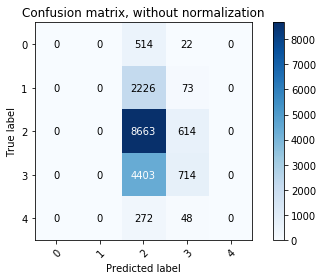

In [27]:
# do now Knn with k = 29 and applie 10 cross fold

# create and fit a knn classifier
knn_reg = KNeighborsClassifier(n_neighbors=5)

knn_reg.fit(features_train, rating_train)
rating_pred_knn = knn_reg.predict(features_test)

print("Scores knn optimized:")

#compute accuracy score

accuracy_knn = cross_val_score(knn_reg, features_train, rating_train, cv=stratified_10_fold_cv, scoring='accuracy')

for i, acc in enumerate(accuracy_knn):
    print("Fold {}: Accuracy = {}%".format(i, acc * 100.0))

print("Average Accuracy = {}%".format(accuracy_knn.mean() * 100.0))
print()
print("Accuracy on Test Data: {}".format(accuracy_score(rating_test, rating_pred_knn)))
print("f1_score on Test Data: {}".format(f1_score(rating_test, rating_pred_knn, average='weighted')))

class_names = ['0','1','2','3','4','5']

print(np.unique(ar=rating_train))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(rating_test, rating_pred_rf, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()


In [44]:
##### create and fit a RandomForestClassifier
rf_reg = RandomForestClassifier()
rf_reg.fit(features_train, rating_train)
rating_pred_rf = rf_reg.predict(features_test)

#Tuning of algorithm

# specify the parameter grid
parameters = {
    'max_depth':[3,5,10,None],
     'criterion':["gini", "entropy"],
     'max_features':["auto","log2",None]
}


# create the grid search instance
grid_search_estimator = GridSearchCV(rf_reg, parameters, scoring='accuracy', cv=stratified_10_fold_cv, return_train_score=False)

# run the grid search
grid_search_estimator.fit(features_train, rating_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
#display(results)
    
# print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))
print()


C:\Users\d060445\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


best score is 0.5175914629871131 with params {'criterion': 'gini', 'max_depth': 10, 'max_features': None}



In [45]:
# do now Random Forest with entropy, maxdeepth 3 and applie 10 cross fold

##### create and fit a RandomForestClassifier
rf_reg = RandomForestClassifier(criterion='gini', max_depth=10, max_features=None)
rf_reg.fit(features_train, rating_train)
rating_pred_rf = rf_reg.predict(features_test)

print("Scores Random Forrest optimized:")


#compute accuracy score

accuracy_knn = cross_val_score(rf_reg, features_train, rating_train, cv=stratified_10_fold_cv, scoring='accuracy')

for i, acc in enumerate(accuracy_knn):
    print("Fold {}: Accuracy = {}%".format(i, acc * 100.0))

print("Average Accuracy = {}%".format(accuracy_knn.mean() * 100.0))
print()
print("Accuracy on Test Data: {}".format(accuracy_score(rating_test, rating_pred_rf)))
print("f1_score on Test Data: {}".format(f1_score(rating_test, rating_pred_rf, average='weighted')))


C:\Users\d060445\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores Random Forrest optimized:
Fold 0: Accuracy = 51.66806840482197%
Fold 1: Accuracy = 51.41575553686572%
Fold 2: Accuracy = 51.32482826300294%
Fold 3: Accuracy = 51.33884760970139%
Fold 4: Accuracy = 52.1312394840157%
Fold 5: Accuracy = 53.2258064516129%
Fold 6: Accuracy = 51.99158485273492%
Fold 7: Accuracy = 51.73236077991304%
Fold 8: Accuracy = 51.35362603450694%
Fold 9: Accuracy = 51.38168046009258%
Average Accuracy = 51.7563797877268%

Accuracy on Test Data: 0.5174894306207013
f1_score on Test Data: 0.4669620780886967


In [58]:
from sklearn.tree import export_graphviz

estimator = rf_reg.estimators_[5]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')


FileNotFoundError: [WinError 2] The system cannot find the file specified